# Advanced Analytics of Fundraising

Predicting fundraising efficiency by Direct Mail

By Steven, Wim and Seppe

In [1]:
### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
### LOADING THE DATA

ext_data_path = "/media/seppe/DiskSpaceInvader/PythonPredictions"

# Test and Train dataset
campaign6169 = pd.read_csv(ext_data_path+"/selection campaign 6169.csv")
campaign7244 = pd.read_csv(ext_data_path+"/selection campaign 7244.csv")
campaign7662 = pd.read_csv(ext_data_path+"/selection campaign 7662 (without gifts).csv")
# General necessary datasets
campaigns = pd.read_csv(ext_data_path+"/campaigns.csv", sep=';')
donors = pd.read_csv(ext_data_path+"/donors.csv", index_col=0)
gifts = pd.read_csv(ext_data_path+"/gifts.csv", index_col=0)
# Additional datasets for new features, courtesy of the governement
pop_den = pd.read_excel("Pop_density_en.xlsx", header=1)
be_codes = pd.read_csv("20170224_mapping_municipalities.csv")

In [3]:
### CLEANING THE DATA

# - Gifts cleaning

gifts['amount'] = pd.Series([str(x).replace(',', '.') for x in gifts['amount']]).astype(float)
# The campaignID 0 is not an actual campaign, but a way of grouping the people who donated outside of a campaign
# Whether this will prove a good idea remains to be seen.
# UPDATE: "meh, could be worse"
gifts['campaignID'].replace(to_replace={np.NaN:0}, inplace=True)
gifts['campaignID'] = gifts['campaignID'].astype(int)
gifts['date'] = pd.to_datetime(gifts['date'],yearfirst=True)

# - Donor Cleaning

# add a year column to the donor df, to find the age of the donor
donors['dateOfBirth'] = pd.to_datetime(donors["dateOfBirth"],yearfirst=True)
donors['year'] = pd.DatetimeIndex(donors['dateOfBirth']).year
# remember when I said I'd find the age of the donor; yeah scrap that, I'm leaving it at this

# drop NaN values. Not sure if I should be doing this; but too lazy to fix it now
donors.dropna(inplace=True)
# change zipcode type to int
donors['zipcode'] = donors['zipcode'].astype(int)
# change gender to 1(Female) or 0(Male), not sure why I'm doing this now, but it's fine, just move along
donors['gender'].replace(to_replace={'F':1,'M':0}, inplace=True)
# There seems to be a small error in the 'province' column, where Antwerp is in All-caps
donors['province'].replace(to_replace={'ANTWERP':'Antwerp'}, inplace=True)

# - Campaign cleaning

# replacing the euro string to a float
campaigns.CostUnit = campaigns.CostUnit.str.slice(start=0, stop=-1)
campaigns.CostUnit = campaigns.CostUnit.str.replace("," , ".")
campaigns.CostUnit = campaigns.CostUnit.astype(float)

campaigns.lettersSent = campaigns.lettersSent.astype(str)
campaigns.lettersSent = campaigns.lettersSent.str.replace("\u202f", "")
campaigns.lettersSent = campaigns.lettersSent.astype(int)

campaigns["Totalcost"] = campaigns.lettersSent * campaigns.CostUnit

campaigns['date'] = pd.to_datetime(campaigns['date'],yearfirst=True)

In [4]:
### REMOVING DATA LATER THAN a GIVEN CAMPAIGN

curr_camp = 7662

# because the date of this campaign isn't known, but it is later than all other campaigns, we can just set  01/06/2020 as the date
campaign_date = pd.to_datetime('01/06/2020')

# Otherwise:
# campaign_date = campaigns.loc[campaigns['campaignID'] == curr_camp].date.values[0]

print("Current campaign date: ",campaign_date)

# Making the target dataframe
target = gifts.loc[gifts['campaignID'] == curr_camp]
target.drop(columns=['campaignID','date'], inplace=True)
target = pd.merge(left=target, right=campaign7662, on='donorID', how='right')
target = target.fillna(value=0.0, axis=1)
print(target.info())

# drop all later dates
campaign_ind = list(campaigns.loc[campaigns['date']>=campaign_date].index)
campaigns.drop(index=campaign_ind, inplace=True)

gift_ind = list(gifts.loc[gifts['date']>=campaign_date].index)
gifts.drop(index=gift_ind, inplace=True)
# Now I get a warning instead of an error, so that's nice, I think

Current campaign date:  2020-01-06 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26522 entries, 0 to 26521
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   amount   26522 non-null  float64
 1   donorID  26522 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 621.6 KB
None


/home/seppe/anaconda3/envs/fundraising/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
### MERGING ALL DATAFRAMES
# cautionary warning; messy naming scheme ahead

# Merging donors and gifts to make funds
df_fund = pd.merge(left=donors, 
                    right=gifts, 
                    how='inner',
                    on='donorID')

# Merging funds with campaign data
df_fund = pd.merge(left=df_fund, right=campaigns, on='campaignID', how='left')
df_fund['date donated']=df_fund['date_x']
df_fund['start of campaign']=pd.to_datetime(df_fund['date_y'],yearfirst=True)
df_fund.drop(['date_x','date_y'], axis=1, inplace=True)

# check which donors donated the nost during different campaigns combined
display(df_fund.groupby('donorID')['amount'].sum().sort_values(ascending=False))
# there seems to be one donor who really sticks out, let's check some more info about this donor
df_fund[df_fund['donorID']==120861]
# because this is such a significant outlier, it probably won't be representative for the rest of the population
# so it could improve results if we drop this outlier <citation needed>
df_fund.drop(df_fund.loc[df_fund['amount']>2000000].index, inplace=True)

donorID
123168    4000030.00
120861    2479000.00
122679      30120.00
105960      13830.37
109635      13718.40
             ...    
130081          5.00
142520          5.00
138583          5.00
142527          5.00
138143          5.00
Name: amount, Length: 44652, dtype: float64

In [6]:
### ADDITIONAL FEATURES

# Population data of municipality (total pop & pop density)
# Frequency of donations (float: times/month)
# Time since last donation (float: num. of months ago)
# Average donation amount (float)
# Donates outside of campaigns (bool)
# Total campaigns contributed (int)
# donors/thousand inhabatants of municapality (float)
# Whether someone already reached their fiscal amount ---- TODO ----
# --> [https://www.vlaanderen.be/geld-en-goederen-schenken]

# Oh and I've got a great idea, what if I use the most inconsistent naming scheme ever?
# 50/50 chance of using an underscore etc.
# Surely this will be an amazing way to confuse my future self 

# 1) Add a location density column to the donor df, to find if the donor lives in a rural area or a city
postal_codes = pd.merge(left=pop_den, right=be_codes, how='inner', 
                        left_on='Refnis', right_on='municipality_nis_code')
postal_codes.drop(columns=['Refnis', 
                           'Municipality FR', 
                           'Size in km²', 
                           'region_nuts_code', 
                           'region_nis_code', 
                           'region_label_nl',
                           'province_nuts_code',
                           'province_nis_code',
                           'province_label_nl',
                           'arrondissement_nuts_code',
                           'arrondissement_nis_code',
                           'arrondissement_label_nl',
                           'municipality_nis_code',
                           'municipality_nis_label_nl',
                           'municipality_label_nl'], inplace=True)
postal_codes.drop_duplicates()
# Merging donors and postal codes
df_fund = pd.merge(left=df_fund,
                    right=postal_codes,
                    how='left',
                    left_on='zipcode',
                    right_on='postcode')
df_fund.drop(columns='postcode', inplace=True)


# Constructing a dictionary to keep key statistics, for .. some reason pobably?
arr = df_fund[['donorID', 'date donated']].to_numpy()
freq_dict = {}
for don in arr:
    if don[0] in freq_dict.keys(): 
        curr = freq_dict[don[0]]
        freq_dict[don[0]] = [curr[0]+1, min(curr[1], don[1]), max(curr[1], don[1])]
    else:
        freq_dict[don[0]] = [1, don[1], don[1]]

column_names={'index': 'donorID', 0:'donations', 1:'first', 2:'last'}
freq_df = pd.DataFrame.from_dict(freq_dict, orient='index')
freq_df.reset_index(drop=False, inplace=True)
freq_df.rename(mapper=column_names, inplace=True, axis='columns')

freq_df['months as donor'] = freq_df['last'] - freq_df['first']
freq_df['months as donor'] = freq_df['months as donor'].astype('timedelta64[M]')
freq_df['frequency'] = freq_df['donations']/freq_df['months as donor']
freq_df['frequency'].replace(to_replace=float('inf'), value=0.0, inplace=True)
freq_df.drop(['first','last'], axis=1, inplace=True)
df_fund = pd.merge(left=df_fund, right=freq_df, on='donorID')

# This is stupid, but it works, so is it really stupid?
recency = df_fund.groupby('donorID')[['date donated']].aggregate(func=max)
recency.rename(mapper={'date donated':'months since gift'}, inplace=True, axis='columns')
recency = recency.apply(lambda x: campaign_date - x)
df_fund = pd.merge(left=df_fund, right=recency, left_on='donorID', right_index=True)
df_fund['months since gift'] = df_fund['months since gift'].astype('timedelta64[M]')

averages = df_fund.groupby('donorID').amount.mean()
df_fund = pd.merge(left=df_fund, right=averages, left_on='donorID', right_index=True)
df_fund.rename(mapper={'amount_x':'amount', 'amount_y':'avg donation'}, inplace=True, axis='columns')

# If I have to use one more groupby() I will actually lose my last remaining braincells
outsidecampaigns = df_fund.groupby('donorID')[['campaignID']].aggregate(func=min)
outsidecampaigns['campaignID'] = [1 if x==0 else 0 for x in outsidecampaigns['campaignID']]
outsidecampaigns.rename(mapper={'campaignID':'donates outside campaign'}, inplace=True, axis='columns')
df_fund = pd.merge(left=df_fund, right=outsidecampaigns, left_on='donorID', right_index=True)

# And some more arts and crafts to keep this messy ship afloat
localdonors = df_fund.groupby('zipcode')[['donorID']].nunique()
localdonors.rename(mapper={'donorID':'local donors'}, inplace=True, axis='columns')
df_fund = pd.merge(left=df_fund, right=localdonors, left_on='zipcode', right_index=True)

df_fund['Population'].fillna(value=df_fund['Population'].median(), inplace=True)
df_fund['Population / km²'].fillna(value=df_fund['Population / km²'].median(), inplace=True)
df_fund['donors/1000 in area'] = df_fund['local donors']/df_fund['Population']*1000


In [7]:
### CREATING A SMALLER FEATURES DATASET

df_fund = pd.concat([df_fund,pd.get_dummies(df_fund['region'], prefix='region')],axis=1)
df_fund = pd.concat([df_fund,pd.get_dummies(df_fund['province'], prefix='province')],axis=1)
df_fund = pd.concat([df_fund,pd.get_dummies(df_fund['language'], prefix='lang')],axis=1)
df_fund.drop(['region','province','language'],axis=1, inplace=True)

# 'Let me freak the funk, obsolete is the punk' ~ Drop, Pharcyde, 1995
features = df_fund.drop(['zipcode',
              'dateOfBirth',
              'Municipality NL',
              'Population',
              'campaignID',
              'amount', 
              'lettersSent', 
              'CostUnit', 
              'Totalcost', 
              'date donated', 
              'start of campaign', 
              'local donors'], axis=1)

features.drop_duplicates(inplace=True, ignore_index=True)

In [8]:
# target_don_list = list(target['donorID'])
# feat_don_list = list(features['donorID'])
# bad_donors = []
# for t in target_don_list:
#     if t not in feat_don_list:
#         bad_donors.append(t)
# print(len(bad_donors), " donors who are not recognized")

# If you don't get what's happening here, don't worry, neither do I
# features = pd.merge(left=target, right=features, on='donorID', how='left')
# features.drop(columns='amount', inplace=True)
# features.set_index('donorID', drop=True, inplace=True)
# target.set_index('donorID', drop=True, inplace=True)

# features.drop(index=bad_donors, inplace=True)
# target.drop(index=bad_donors, inplace=True)

print(features.info())
print(features.head(10))
print(target.info())
print(target.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44651 entries, 0 to 44650
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   donorID                   44651 non-null  int64  
 1   gender                    44651 non-null  int64  
 2   year                      44651 non-null  int64  
 3   Population / km²          44651 non-null  float64
 4   donations                 44651 non-null  int64  
 5   months as donor           44651 non-null  float64
 6   frequency                 44651 non-null  float64
 7   months since gift         44651 non-null  float64
 8   avg donation              44651 non-null  float64
 9   donates outside campaign  44651 non-null  int64  
 10  donors/1000 in area       44651 non-null  float64
 11  region_Brussels           44651 non-null  uint8  
 12  region_Flanders           44651 non-null  uint8  
 13  region_Wallonia           44651 non-null  uint8  
 14  provin

In [9]:
### STORING THE DATASETS

# target.to_csv("target"+str(curr_camp)+".csv")
features.to_csv("features"+str(curr_camp)+".csv")
df_fund.to_csv(ext_data_path+"/df_fund"+str(curr_camp)+".csv")

How frequently a candidate donor makes donations?

When was the last time a candidate donors made a donation?

What is the average donation amount of a candidate donors?

Is a candidate donors making donation during reactivation campaign, or spontaneously?

You can look at this variable over the short term (last months), long term (last years) and/or
lifetime.

In [18]:
features['Region']=(features['region_Brussels']*1)+(features['region_Flanders']*2)+(features['region_Wallonia']*3)

In [38]:
features.groupby('Region')['donates outside campaign'].sum()

Region
1     137
2    5523
3     144
Name: donates outside campaign, dtype: int64

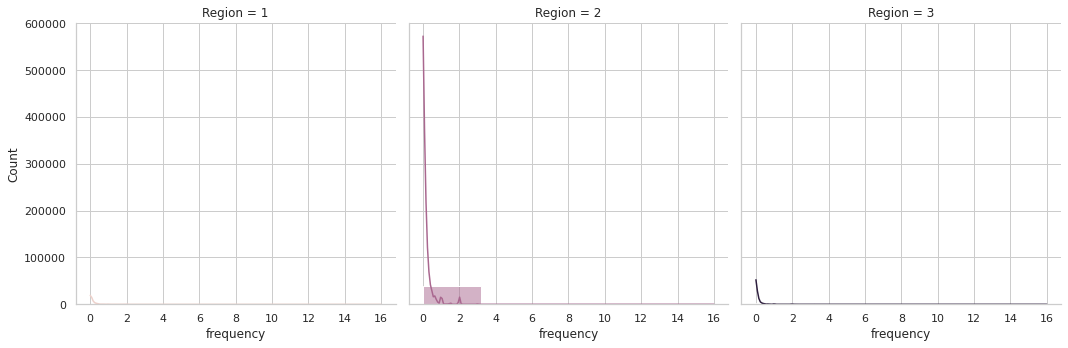

In [34]:
sns.set_theme(context="notebook", style='whitegrid')
sns.displot(data=features, x='frequency', bins=5, col='Region',hue='Region', kde=True, legend=False)

plt.show()

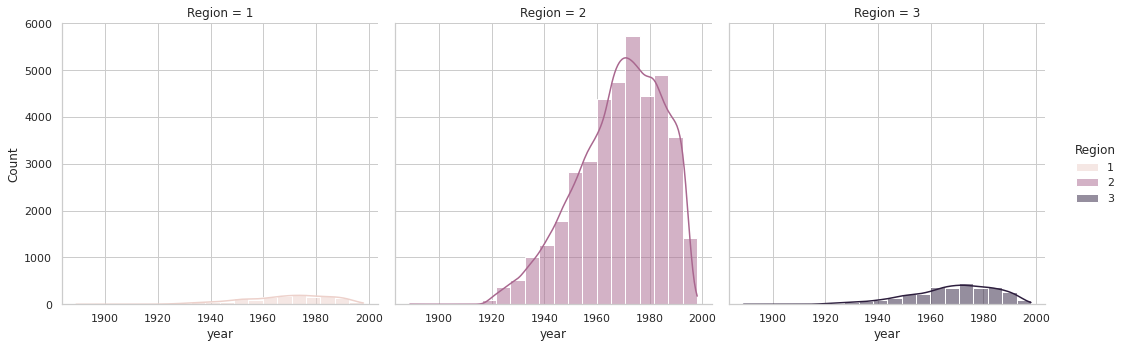

In [28]:
sns.displot(data=features, x='year', bins=20, col='Region',hue='Region', kde=True)
plt.show()